**This notebook is an exercise in the [Computer Vision](https://www.kaggle.com/learn/computer-vision) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/convolution-and-relu).**

---


# Introduction #

In this exercise, you'll work on building some intuition around feature extraction. First, we'll walk through the example we did in the tutorial again, but this time, with a kernel you choose yourself. We've mostly been working with images in this course, but what's behind all of the operations we're learning about is mathematics. So, we'll also take a look at how these feature maps can be represented instead as arrays of numbers and what effect convolution with a kernel will have on them.

Run the cell below to get started!

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex2 import *

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

tf.config.run_functions_eagerly(True)

2024-04-04 09:21:28.132833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 09:21:28.132938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 09:21:28.283637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Apply Transformations #

The next few exercises walk through feature extraction just like the example in the tutorial. Run the following cell to load an image we'll use for the next few exercises.

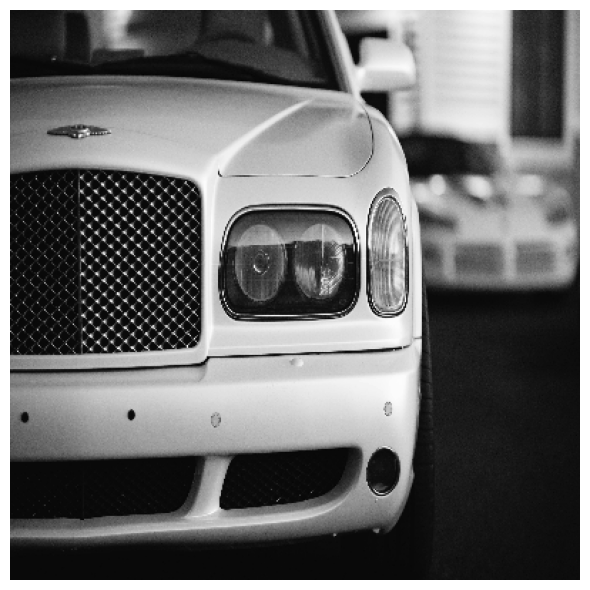

In [2]:
image_path = '../input/computer-vision-resources/car_illus.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

img = tf.squeeze(image).numpy()
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show();

You can run this cell to see some standard kernels used in image processing.

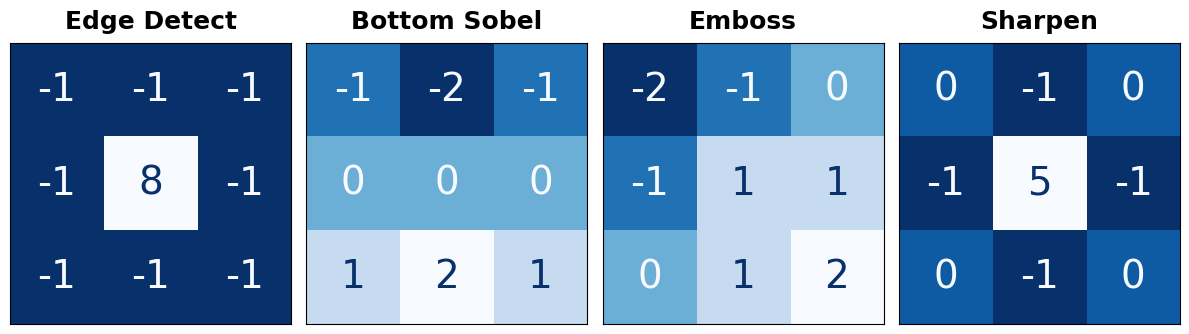

In [3]:
import learntools.computer_vision.visiontools as visiontools
from learntools.computer_vision.visiontools import edge, bottom_sobel, emboss, sharpen

kernels = [edge, bottom_sobel, emboss, sharpen]
names = ["Edge Detect", "Bottom Sobel", "Emboss", "Sharpen"]

plt.figure(figsize=(12, 12))
for i, (kernel, name) in enumerate(zip(kernels, names)):
    plt.subplot(1, 4, i+1)
    visiontools.show_kernel(kernel)
    plt.title(name)
plt.tight_layout()

# 1) Define Kernel #

Use the next code cell to define a kernel. You have your choice of what kind of kernel to apply. One thing to keep in mind is that the *sum* of the numbers in the kernel determines how bright the final image is. Generally, you should try to keep the sum of the numbers between 0 and 1 (though that's not required for a correct answer).

In general, a kernel can have any number of rows and columns. For this exercise, let's use a $3 \times 3$ kernel, which often gives the best results. Define a kernel with `tf.constant`.

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

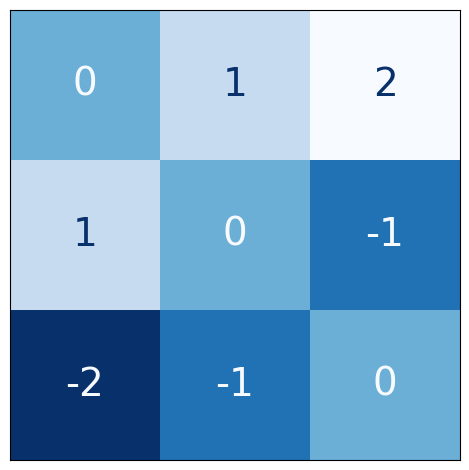

In [4]:
# YOUR CODE HERE: Define a kernel with 3 rows and 3 columns.
kernel = tf.constant([
    [0, 1, 2],
    [1, 0, -1],
    [-2, -1, 0]
])
# Uncomment to view kernel
# visiontools.show_kernel(kernel)
visiontools.show_kernel(kernel)

# Check your answer
q_1.check()

In [5]:
# Lines below will give you a hint or solution code
#q_1.hint()
#q_1.solution()

Now we'll do the first step of feature extraction, the filtering step. First run this cell to do some reformatting for TensorFlow.

In [6]:
# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

# 2) Apply Convolution #

Now we'll apply the kernel to the image by a convolution. The *layer* in Keras that does this is `layers.Conv2D`. What is the *backend function* in TensorFlow that performs the same operation?

In [10]:
# YOUR CODE HERE: Give the TensorFlow convolution function (without arguments)
conv_fn = tf.nn.conv2d

# Check your answer
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [11]:
# Lines below will give you a hint or solution code
#q_2.hint()
#q_2.solution()

Once you've got the correct answer, run this next cell to execute the convolution and see the result!

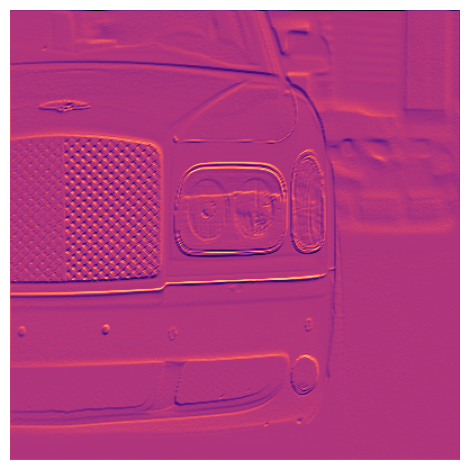

In [12]:
image_filter = conv_fn(
    input=image,
    filters=kernel,
    strides=1, # or (1, 1)
    padding='SAME',
)

plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_filter)
)
plt.axis('off')
plt.show();

Can you see how the kernel you chose relates to the feature map it produced?

# 3) Apply ReLU #

Now detect the feature with the ReLU function. In Keras, you'll usually use this as the activation function in a `Conv2D` layer. What is the *backend function* in TensorFlow that does the same thing?

In [13]:
# YOUR CODE HERE: Give the TensorFlow ReLU function (without arguments)
relu_fn = tf.nn.relu

# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [14]:
# Lines below will give you a hint or solution code
#q_3.hint()
#q_3.solution()

Once you've got the solution, run this cell to detect the feature with ReLU and see the result!

The image you see below is the feature map produced by the kernel you chose. If you like, experiment with some of the other suggested kernels above, or, try to invent one that will extract a certain kind of feature.


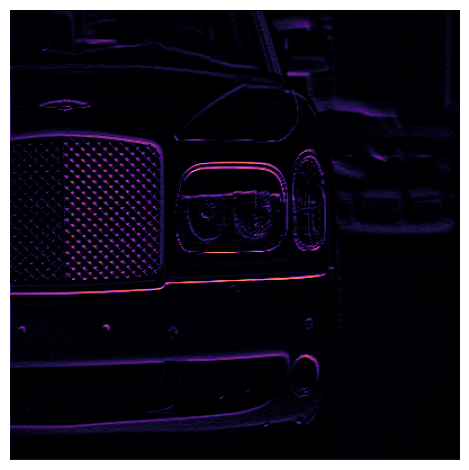

In [15]:
image_detect = relu_fn(image_filter)

plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_detect)
)
plt.axis('off')
plt.show();

In the tutorial, our discussion of kernels and feature maps was mainly visual. We saw the effect of `Conv2D` and `ReLU` by observing how they transformed some example images.

But the operations in a convolutional network (like in all neural networks) are usually defined through mathematical functions, through a computation on numbers. In the next exercise, we'll take a moment to explore this point of view.

Let's start by defining a simple array to act as an image, and another array to act as the kernel. Run the following cell to see these arrays.

In [16]:
# Sympy is a python library for symbolic mathematics. It has a nice
# pretty printer for matrices, which is all we'll use it for.
import sympy
sympy.init_printing()
from IPython.display import display

image = np.array([
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1],
    [0, 1, 0, 0, 0, 0],
])

kernel = np.array([
    [1, -1],
    [1, -1],
])

display(sympy.Matrix(image))
display(sympy.Matrix(kernel))
# Reformat for Tensorflow
image = tf.cast(image, dtype=tf.float32)
image = tf.reshape(image, [1, *image.shape, 1])
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

⎡0  1  0  0  0  0⎤
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  1  0  1  1  1⎥
⎢                ⎥
⎣0  1  0  0  0  0⎦

⎡1  -1⎤
⎢     ⎥
⎣1  -1⎦

# 4) Observe Convolution on a Numerical Matrix #


What do you see? The image is simply a long vertical line on the left and a short horizontal line on the lower right. What about the kernel? What effect do you think it will have on this image? After you've thought about it, run the next cell for the answer.

In [ ]:
# View the solution (Run this code cell to receive credit!)
q_4.check()

Now let's try it out. Run the next cell to apply convolution and ReLU to the image and display the result.

In [ ]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)
image_detect = tf.nn.relu(image_filter)

# The first matrix is the image after convolution, and the second is
# the image after ReLU.
display(sympy.Matrix(tf.squeeze(image_filter).numpy()))
display(sympy.Matrix(tf.squeeze(image_detect).numpy()))

Is the result what you expected?

# Conclusion #

In this lesson, you learned about the first two operations a convolutional classifier uses for feature extraction: **filtering** an image with a **convolution** and **detecting** the feature with the **rectified linear unit**. 

# Keep Going #

Move on to [**Lesson 3**](https://www.kaggle.com/ryanholbrook/maximum-pooling) to learn the final operation: **condensing** the feature map with **maximum pooling**!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/computer-vision/discussion) to chat with other learners.*